In [3]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase2 import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [31]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,verbose)
        self.mem = {}
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            noChoices = random.randint(1,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda summary2,goal: ["
        pos = []
        neg = []
        posMatch = []
        negMatch = []
        notZero = 0
        for gen in chromosome.genes:
            temp2 = []
            temp3 = []
            isZero = True
            for val in gen.value:
                if val != -1:
                    isZero=False
                    temp = f"summary2[{gen.identifier}][{val}][goal] if goal in summary2[{gen.identifier}][{val}] else set()"
                    temp2.append(temp)
                    for goal in self.goals:
                        if goal != -1:
                            temp3.append(f"summary2[{gen.identifier}][{val}][{goal}] if goal != {goal} and {goal} in summary2[{gen.identifier}][{val}] else set()")
            notZero += 1 if not isZero else 0
            pos.append(f"set([]).union(*[{','.join(temp2)}])")
            neg.append(f"set([]).union(*[{','.join(temp3)}])")
        rule += f"[{','.join(pos)}],[{','.join(neg)}],{notZero if notZero > 0 else 100000}"+"]"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        totalPosMatch,totalNegMatch,noChromosomes = matchProportion(self.summarized2,goal)
        countPosMatch = 0
        for row in totalPosMatch:
            for col in row:
                countPosMatch += self.matrix[col][1]
        countPosMatch = countPosMatch / noChromosomes
        countNegMatch = 0
        for row in totalNegMatch:
            for col in row:
                countNegMatch += self.matrix[col][1]
        countNegMatch = countNegMatch / noChromosomes
        totalPos = self.summarized["total"][goal]
        totalNeg = self.summarized["total"]["total"]-self.summarized["total"][goal]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples) 
        negProp = (totalNeg/totalExamples) 
        total = (countPosMatch * negProp) + (-1*countNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        res = total/maxTotal
        return res
    
    def regulation(self,population):
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = [x for x in range(1,len(population.chromosomes))]
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 1
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .5
        self.noChromosomes = 100
        self.noIterations = 200
        super().setup()

In [32]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatchDynamic = 0
        totalMatchStatic = 0
        totalStatic = 0
        totalDynamic = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatchDynamic += (cell0 != cell1 and cell1 == cell2)
            totalMatchStatic += (cell0 == cell1 and cell1 == cell2)
            totalStatic += (cell0 == cell1)
            totalDynamic += (cell0 != cell1)
        totalStatic = totalStatic if totalStatic > 0 else 0
        totalDynamic = totalDynamic if totalDynamic > 0 else 0
        return [totalStatic,totalDynamic,totalMatchStatic,totalMatchDynamic]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: 
                    print(f"Static : {summation[2]}/{summation[0]}")
                    print(f"Dynamic : {summation[3]}/{summation[1]}")
                totalStatic = summation[2]/summation[0] if summation[0] > 0 else 0
                totalDynamic = summation[3]/summation[1] if summation[1] > 0 else 0
                res.append([totalStatic,totalDynamic])
        self.result = np.array(res)
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result[:,0])
        plt.plot(range(len(self.result)),self.result[:,1])
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

In [39]:
data  = np.load("data/wildfire.npy")
train = math.floor(len(data) * 0.8)
exp2 = Experiment1(data[:train],"Experiment2","2dfire_exp4",verbose=2)
exp2.run()

start setup
Start 1 (50, 50)
Start 2 (50, 50)Start 3 (50, 50)

Start 4 (50, 50)
middle 1.875683069229126
middle 1.8816251754760742middle 1.8863868713378906middle 1.8991570472717285


End 1 1.919166088104248End 2 1.9591569900512695

Start 5 (50, 50)
Start 6 (50, 50)End 4 1.9746301174163818

End 3 1.9839999675750732Start 7 (50, 50)

Start 8 (50, 50)
middle 2.7137229442596436
End 8 2.761996030807495
Start 9 (50, 50)
middle 2.811789035797119
middle 2.8519668579101562middle 2.867842674255371End 7 2.8437697887420654


Start 10 (50, 50)End 5 2.914807081222534
End 6 2.9614241123199463Start 11 (50, 50)

Start 12 (50, 50)

middle 2.015155076980591
End 9 2.048074960708618
Start 13 (50, 50)
middle 2.041491985321045middle 2.026582956314087

End 12 2.0749478340148926middle 2.1859681606292725End 11 2.0909790992736816
Start 14 (50, 50)


Start 15 (50, 50)
End 10 2.225083112716675
Start 16 (50, 50)
middle 1.686532735824585
End 13 1.726485013961792
Start 17 (50, 50)
middle 1.7097811698913574
End 15 1.73

In [35]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [37]:
prediction = []
for it in model.run(data[0],50):
    prediction.append(it[1])

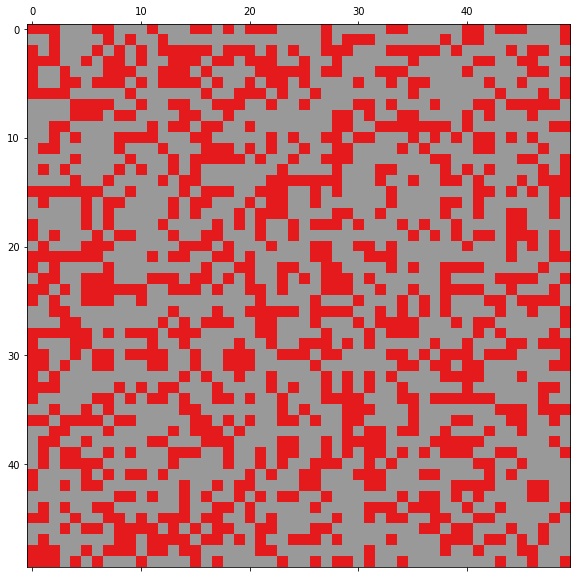

In [38]:
helpers.animate(prediction)

Testing:
state 1/50
Static : 985/2496
Dynamic : 3/4
state 2/50
Static : 986/2493
Dynamic : 4/7
state 3/50
Static : 989/2491
Dynamic : 5/9
state 4/50
Static : 993/2490
Dynamic : 5/10
state 5/50
Static : 998/2491
Dynamic : 4/9
state 6/50
Static : 1003/2492
Dynamic : 4/8
state 7/50
Static : 1007/2492
Dynamic : 4/8
state 8/50
Static : 1011/2492
Dynamic : 4/8
state 9/50
Static : 1015/2492
Dynamic : 4/8
state 10/50
Static : 1019/2492
Dynamic : 4/8
state 11/50
Static : 1023/2488
Dynamic : 8/12
state 12/50
Static : 1027/2483
Dynamic : 9/17
state 13/50
Static : 1035/2483
Dynamic : 8/17
state 14/50
Static : 1044/2487
Dynamic : 5/13
state 15/50
Static : 1052/2489
Dynamic : 6/11
state 16/50
Static : 1057/2485
Dynamic : 9/15
state 17/50
Static : 1063/2480
Dynamic : 11/20
state 18/50
Static : 1072/2479
Dynamic : 10/21
state 19/50
Static : 1083/2479
Dynamic : 11/21
state 20/50
Static : 1093/2475
Dynamic : 14/25
state 21/50
Static : 1104/2466
Dynamic : 20/34
state 22/50
Static : 1118/2461
Dynamic : 19

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

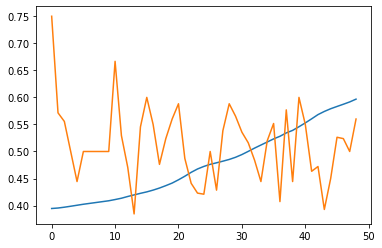

In [36]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

In [13]:
visualization = Visualization("2dfire_exp3/18_12_19_09_50_39")

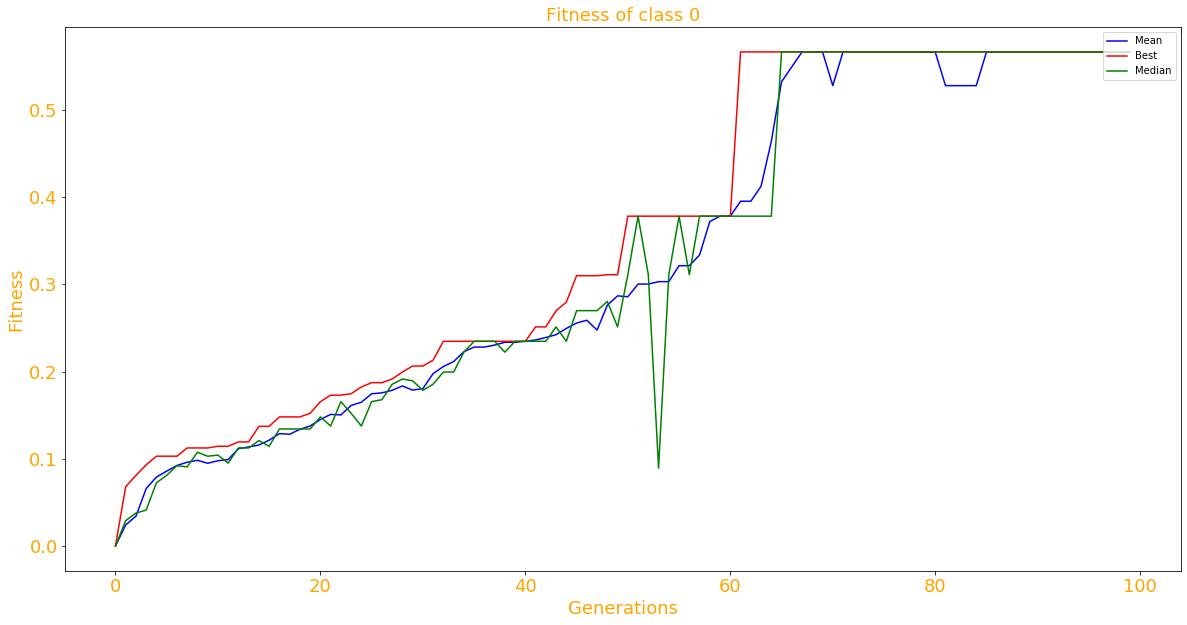

In [14]:
visualization.getFitnessGraph("0")

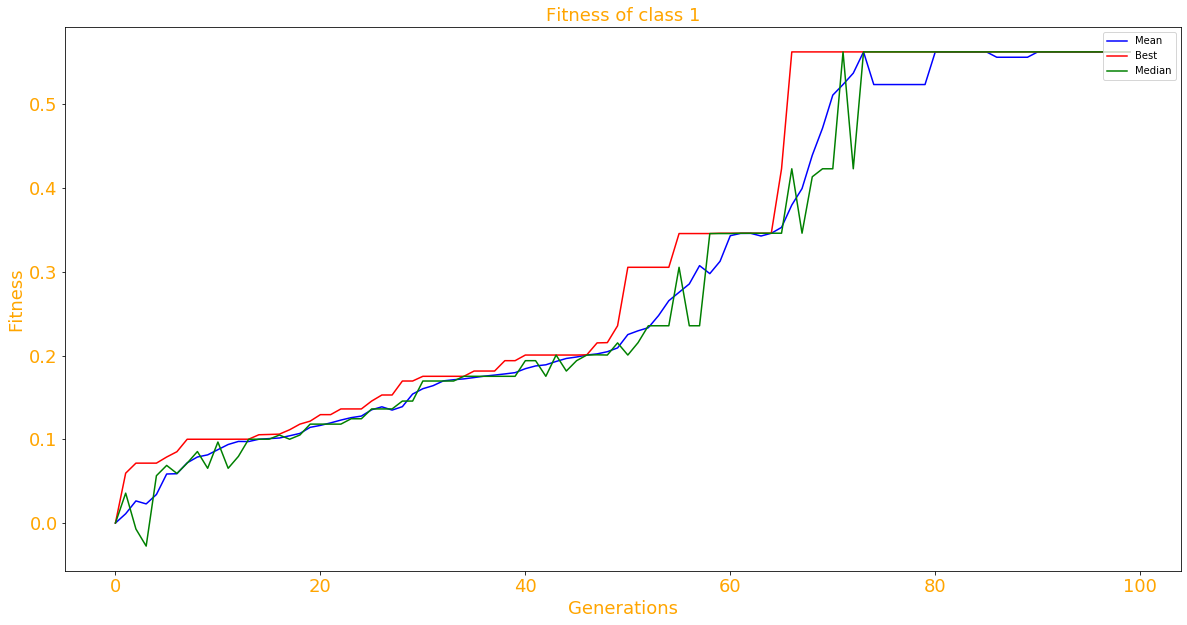

In [15]:
visualization.getFitnessGraph("1")

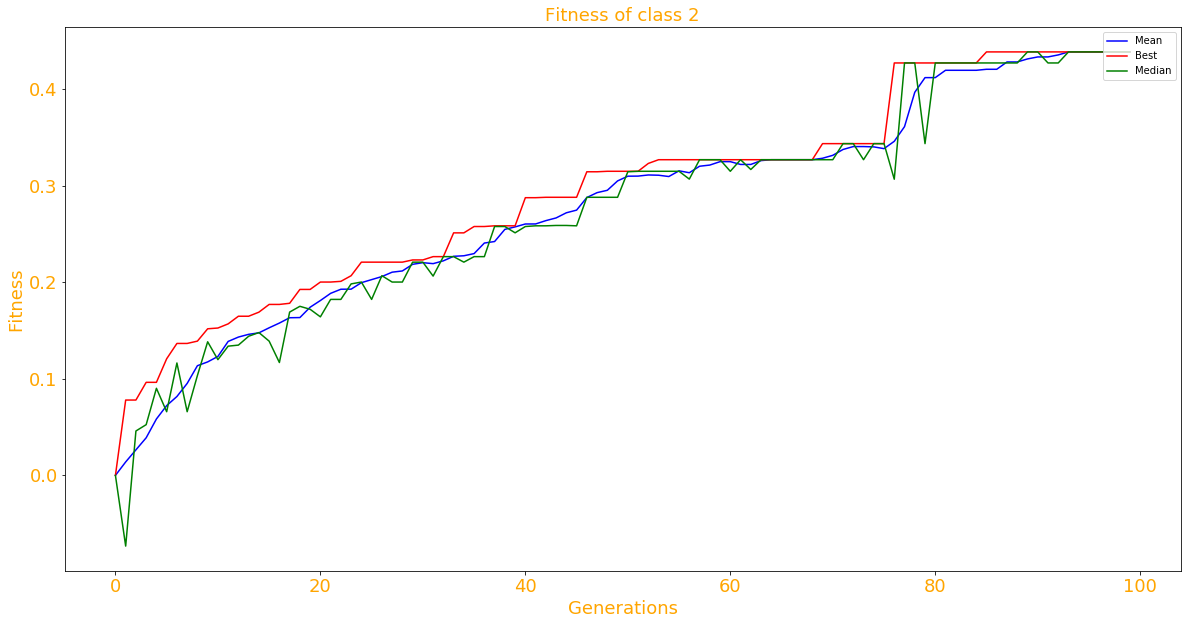

In [16]:
visualization.getFitnessGraph("2")

In [18]:
transformer.lmstr

{0: 'lambda x: (x[12] in {0} if x[12] != -1 else True) and (x[13] in {0, 2} if x[13] != -1 else True)',
 1: 'lambda x: (x[8] in {1, 2} if x[8] != -1 else True) and (x[12] in {1} if x[12] != -1 else True)',
 2: 'lambda x: (x[12] in {1} if x[12] != -1 else True) and (x[17] in {2} if x[17] != -1 else True)'}

In [62]:
exp2.world.toDict()

{'generation': 99,
 'populations': [{'generation': 99,
   'goal': '0',
   'chromosomes': [{'uuid': '69864558-f3a0-41fa-b837-91d64974b952',
     'generation': 95,
     'genes': [{'identifier': '0', 'value': 'set()'},
      {'identifier': '1', 'value': 'set()'},
      {'identifier': '2', 'value': 'set()'},
      {'identifier': '3', 'value': '{-1}'},
      {'identifier': '4', 'value': 'set()'},
      {'identifier': '5', 'value': 'set()'},
      {'identifier': '6', 'value': 'set()'},
      {'identifier': '7', 'value': 'set()'},
      {'identifier': '8', 'value': 'set()'},
      {'identifier': '9', 'value': '{0, 2}'},
      {'identifier': '10', 'value': 'set()'},
      {'identifier': '11', 'value': 'set()'},
      {'identifier': '12', 'value': '{0}'},
      {'identifier': '13', 'value': '{-1}'},
      {'identifier': '14', 'value': 'set()'},
      {'identifier': '15', 'value': 'set()'},
      {'identifier': '16', 'value': '{-1}'},
      {'identifier': '17', 'value': '{-1}'},
      {'identifi

In [57]:
import sys
del sys.modules["ExperimentBase"]